In [18]:
from pgmpy.models import BayesianNetwork

from pgmpy.factors.discrete.CPD import TabularCPD

from pgmpy.inference import VariableElimination

import networkx as nx

In [7]:
game_model = BayesianNetwork(
    [
        ("Card1", "Card2"),
        ("Card1", "Round1"),
        ("Card1", "Round3"),
        ("Card2", "Round2"),
        ("Round1", "Round2"),
        ("Round2", "Round3"),
        ("Round1", "Round3")
    ]
)

In [10]:
# regina de inima, regina de frunza, rege de inima, rege de frunza, as de frunza
cpd_card1 = TabularCPD(
    variable="Card1", variable_card=5, values=[[0.2], [0.2], [0.2], [0.2], [0.2]]
)
cpd_card2 = TabularCPD(
    variable="Card2",
    variable_card=5,
    values=[
        [0, 0.25, 0.25, 0.25, 0.25], [0.25, 0, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0, 0.25, 0.25], [0.25, 0.25, 0.25, 0, 0.25],
        [0.25, 0.25, 0.25, 0.25, 0]],
    evidence=["Card1"],
    evidence_card=[5],
)
# 1st value -> skip, 2nd -> bet
cpd_round1= TabularCPD(
    variable="Round1",
    variable_card=2,
    values=[
        [0.7, 0.5, 0.3, 0.15, 0], [0.3, 0.5, 0.7, 0.85, 1]],
    evidence=["Card1"],
    evidence_card=[5],
)
# 1st value -> skip, 2nd -> bet, 3rd -> leave
cpd_round2 = TabularCPD(
    variable="Round2",
    variable_card=3,
    values=[
        # card(0) skip, bet ; card(1) skip, bet
        #skip
        [0.9, 0000, 0.7, 0000, 0.3, 0000, 0.15, 0000, 0.05, 0], 
        # bet
        [0.1, 0.15, 0.3, 0.85, 0.7, 0.55, 0.85, 0.70, 0.95, 1],
        # leave
        [000, 0.85, 000, 0.15, 000, 0.45, 0000, 0.30, 0000, 0]],
    evidence=["Card2", "Round1"],
    evidence_card=[5, 2],
)
# 1st value -> leave, 2nd -> bet, 3rd -> didnt happen
cpd_round3 = TabularCPD(
    variable="Round3",
    variable_card=3,
    values=[
        # leave
        # card(0)
        # round1skip->r2skip r2bet r2leave + round1bet->r2skip r2bet r2leave
        [0, 1, 0, 0, 0, 0, 
         #card(1)
         0, 0.7, 0, 0, 0, 0,
         #card(2)
         0, 0.4, 0, 0, 0, 0,
         #card(3)
         0, 0.2, 0, 0, 0, 0,
         #card(4)
         0, 0, 0, 0, 0, 0], 
        
        # bet
        # card(0)
        # round1skip->r2skip r2bet r2leave + round1bet->r2skip r2bet r2leave
        [0, 0, 0, 0, 0, 0,
         #card(1)
         0, 0.3, 0, 0, 0, 0,
         #card(2)
         0, 0.6, 0, 0, 0, 0,
         #card(3)
         0, 0.8, 0, 0, 0, 0,
         #card(4)
         0, 1, 0, 0, 0, 0],
        
        # didnt happen
        # card(0)
        # round1skip->r2skip r2bet r2leave + round1bet->r2skip r2bet r2leave
        [1, 0, 1, 1, 1, 1,
         #card(1)
         1, 0, 1, 1, 1, 1,
         #card(2)
         1, 0, 1, 1, 1, 1,
         #card(3)
         1, 0, 1, 1, 1, 1,
         #card(4)
         1, 0, 1, 1, 1, 1]
        ],    
    evidence=["Card1", "Round1", "Round2"],
    evidence_card=[5, 2, 3],
)

In [11]:
game_model.add_cpds(
    cpd_card1, cpd_card2, cpd_round1, cpd_round2, cpd_round3
)

In [12]:
game_model.check_model()

True

In [15]:
game_model.local_independencies(["Card1", "Card2", "Round1", "Round1", "Round3"])

(Card2 ⟂ Round1 | Card1)
(Round1 ⟂ Card2 | Card1)
(Round1 ⟂ Card2 | Card1)
(Round3 ⟂ Card2 | Round2, Card1, Round1)

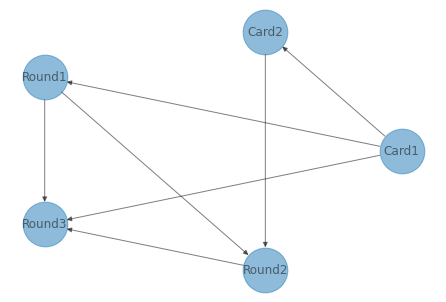

In [17]:
pos = nx.circular_layout(game_model)
nx.draw(game_model, with_labels=True, pos=pos, alpha=0.5, node_size=2000)

In [26]:
infer = VariableElimination(game_model)

In [34]:
# Esti Jucatorul 1 si ai primit un Rege de Frunza, ar trebui sa pariezi sau nu?
# cautam care e probabilitatea castigului pentru cazul in care am pariat, si in cazul in care nu
# alegem maximul => raspunsul daca trebuie sa pariem sau nu

print(infer.query(["Round1","Round2", "Round3", "Card2"], evidence={"Card1": 3}))

+-----------+-----------+-----------+----------+-----------------------------------+
| Round1    | Round2    | Round3    | Card2    |   phi(Round1,Round2,Round3,Card2) |
+===========+===========+===========+==========+===================================+
| Round1(0) | Round2(0) | Round3(0) | Card2(0) |                            0.0000 |
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(0) | Round2(0) | Round3(0) | Card2(1) |                            0.0000 |
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(0) | Round2(0) | Round3(0) | Card2(2) |                            0.0000 |
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(0) | Round2(0) | Round3(0) | Card2(3) |                            0.0000 |
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(0) | Round2(0) | Round3(0) | Card2(4) |                 

In [ ]:
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1    | Round2    | Round3    | Card2    |   phi(Round1,Round2,Round3,Card2) |
+===========+===========+===========+==========+===================================+
| Round1(0) | Round2(0) | Round3(2) | Card2(0) |                            0.0338 |  -->  0
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(0) | Round2(0) | Round3(2) | Card2(1) |                            0.0263 |  -->  0
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(0) | Round2(0) | Round3(2) | Card2(2) |                            0.0113 |  -->  0
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(0) | Round2(0) | Round3(2) | Card2(4) |                            0.0019 |  -->  0
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(0) | Round2(1) | Round3(0) | Card2(0) |                            0.0008 |  --> -1
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(0) | Round2(1) | Round3(0) | Card2(1) |                            0.0023 |  --> -1
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(0) | Round2(1) | Round3(0) | Card2(2) |                            0.0053 |  --> -1
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(0) | Round2(1) | Round3(0) | Card2(4) |                            0.0071 |  --> -1
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(0) | Round2(1) | Round3(1) | Card2(0) |                            0.0030 |  -->  2
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(0) | Round2(1) | Round3(1) | Card2(1) |                            0.0090 |  -->  2
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(0) | Round2(1) | Round3(1) | Card2(2) |                            0.0210 |  -->  2
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(0) | Round2(1) | Round3(1) | Card2(4) |                            0.0285 |  --> -2
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(1) | Round2(1) | Round3(2) | Card2(0) |                            0.0319 |  -->  2
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(1) | Round2(1) | Round3(2) | Card2(1) |                            0.1806 |  -->  2
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(1) | Round2(1) | Round3(2) | Card2(2) |                            0.1169 |  -->  2
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(1) | Round2(1) | Round3(2) | Card2(4) |                            0.2125 |  --> -2
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(1) | Round2(2) | Round3(2) | Card2(0) |                            0.1806 |  -->  1
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(1) | Round2(2) | Round3(2) | Card2(1) |                            0.0319 |  -->  1
+-----------+-----------+-----------+----------+-----------------------------------+
| Round1(1) | Round2(2) | Round3(2) | Card2(2) |                            0.0956 |  -->  1
+-----------+-----------+-----------+----------+-----------------------------------+

# adunand probabilitati pentru diverse castiguri vom obtine:

# daca nu pariem:
# Probabilitatea de a obtine castigul = 0 este: 0.0733
# Probabilitatea de a obtine castigul = -1 este: 0.0155
# Probabilitatea de a obtine castigul = 1 este: 0
# Probabilitatea de a obtine castigul = 2 este: 0.033
# Probabilitatea de a obtine castigul = -2 este: 0.0285

# daca pariem:
# Probabilitatea de a obtine castigul = 0 este: 0
# Probabilitatea de a obtine castigul = -1 este: 0.0155
# Probabilitatea de a obtine castigul = 1 este: 0.3081
# Probabilitatea de a obtine castigul = 2 este: 0.3294
# Probabilitatea de a obtine castigul = -2 este: 0.2125

# RASPUNS: astfel, probabilitatea de a castiga ceva este mai mare in cazul in care pariem => ar trebui sa pariem daca obtin un rege de frunza

In [36]:
# Esti Jucatorul 2 si ai primit un Rege de Inima iar Jucatorul 1 a decis sa parieze. Cum ar trebui sa decizi?
# cautam care e probabilitatea castigului pentru cazul in care am pariat, si in cazul in care nu
# alegem maximul => raspunsul daca trebuie sa pariem sau nu

print(infer.query(["Round2", "Round3", "Card1"], evidence={"Card2": 2, "Round1": 1}))

+-----------+-----------+----------+----------------------------+
| Round2    | Round3    | Card1    |   phi(Round2,Round3,Card1) |
+===========+===========+==========+============================+
| Round2(0) | Round3(0) | Card1(0) |                     0.0000 |
+-----------+-----------+----------+----------------------------+
| Round2(0) | Round3(0) | Card1(1) |                     0.0000 |
+-----------+-----------+----------+----------------------------+
| Round2(0) | Round3(0) | Card1(2) |                     0.0000 |
+-----------+-----------+----------+----------------------------+
| Round2(0) | Round3(0) | Card1(3) |                     0.0000 |
+-----------+-----------+----------+----------------------------+
| Round2(0) | Round3(0) | Card1(4) |                     0.0000 |
+-----------+-----------+----------+----------------------------+
| Round2(0) | Round3(1) | Card1(0) |                     0.0000 |
+-----------+-----------+----------+----------------------------+
| Round2(0

In [ ]:
+-----------+-----------+----------+----------------------------+
| Round2    | Round3    | Card1    |   phi(Round2,Round3,Card1) |
+===========+===========+==========+============================+
| Round2(1) | Round3(2) | Card1(0) |                     0.0623 |   --> 2
+-----------+-----------+----------+----------------------------+
| Round2(1) | Round3(2) | Card1(1) |                     0.1038 |   --> 2
+-----------+-----------+----------+----------------------------+
| Round2(1) | Round3(2) | Card1(3) |                     0.1764 |   --> -2
+-----------+-----------+----------+----------------------------+
| Round2(1) | Round3(2) | Card1(4) |                     0.2075 |   --> -2
+-----------+-----------+----------+----------------------------+
| Round2(2) | Round3(2) | Card1(0) |                     0.0509 |   --> -1
+-----------+-----------+----------+----------------------------+
| Round2(2) | Round3(2) | Card1(1) |                     0.0849 |   --> -1
+-----------+-----------+----------+----------------------------+
| Round2(2) | Round3(2) | Card1(3) |                     0.1443 |   --> -1
+-----------+-----------+----------+----------------------------+
| Round2(2) | Round3(2) | Card1(4) |                     0.1698 |   --> -1
+-----------+-----------+----------+----------------------------+

# dupa cum putem observa: avem sansa la un castig doar daca pariem (castigurile fiind cele scrise in dreptul fiecarei linii)
# RASPUNS: VOM PARIA

In [ ]:
# pentru a schimba raspunsul la intrebare putem inversa probabilitatile ce tine de carti, prezentate mai sus, adica
# odata avand o carte mai mare, eu voi decide sa nu pariez si cu cat cartea va scadea dorinta mea de a paria va creste
# astfel, raspunsurile vor fi inversate